In [10]:
import matplotlib.pyplot as plt
from PIL import Image
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from sklearn import svm
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier

# Question 1

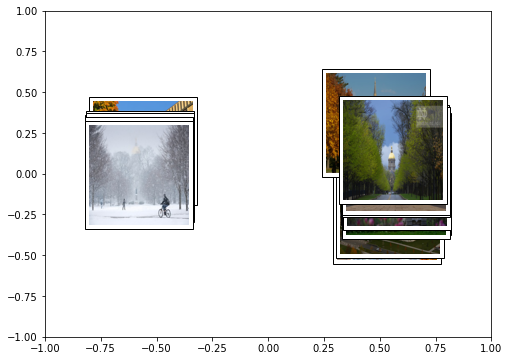

In [11]:
size_100 = (100,100)
path = "images"

def loadImages(path):

    '''
    :param path: absolute path of images
    :return: 2 arrays. The first one is an numpy array of numpy arrays
    30 rows of (10000,3). 100*100 pixels each one described
    by a tuple of 3 values (r,g,b)
    The second one dimensional array contains the image labels
    '''
    listOfImages = []
    labels = []
    for imageFileName in os.listdir(path):
        image = Image.open(path+"/"+imageFileName)
        image = image.resize(size_100)
        '''
        we reshape every image to an 1d array with size 100*100.
        each row contains a tuple with (r,g,b) values
        '''
        listOfImages.append(np.reshape(image, (100*100,3)))
        if imageFileName.startswith('W'):
            labels.append(0)
        elif imageFileName.startswith('F'):
            labels.append(1)
        else:
            imageFileName.startswith('S')
            labels.append(2)
    return np.asarray(listOfImages),np.asarray(labels)

def PCA_ImageSpaceVisualization(images):
    pcaComponents = []
    projectedImages = []

    for image in images:
        pca = PCA(2).fit(image)
        projectedImage = pca.transform(image)
        pcaComponents.append(pca)
        projectedImages.append(projectedImage)

    centroids = []
    # for projectedImage in projectedImages:
    #     centroids.append([np.mean(projectedImage[:,0]),np.mean(projectedImage[:,1])])
    # centroidsNormalized = normalize(centroids)
    for pcaComponent in pcaComponents:
        components = pcaComponent.components_.T
        centroids.append([np.mean(components[:,0]),np.mean(components[:,1])])

    fig, ax = plt.subplots(figsize=(8, 6))
    for n,projectedImage in enumerate(projectedImages):
        imagebox = OffsetImage(np.reshape(images[n], (100,100,3)))
        imagebox.image.axes = ax
        ab = AnnotationBbox(imagebox,xy = centroids[n])
        ax.add_artist(ab)
        ax.set_xlim(-1,1)
        ax.set_ylim(-1,1)
    plt.draw()
    plt.show()
    return projectedImages

def normalize(points):
    row_sums = np.array(points).sum(axis=1)
    return np.array(points) / row_sums[:, np.newaxis]

images, labels = loadImages(path)
compressedImages = PCA_ImageSpaceVisualization(images)

## 2.1)

## 2.2)

In [12]:
def classification(images,labels):
    """
    flatten images to size (100*100*3,1)
    so as to match the knn input data
    """
    images = [np.reshape(image,-1) for image in images]
    knn = KNeighborsClassifier(1)
    scores = cross_val_score(knn, images, labels, cv=5, scoring='accuracy')
    knn_mean = scores.mean()

    svm_clf = svm.SVC(kernel='linear', C=1)
    scores = cross_val_score(svm_clf, images, labels, cv=5, scoring='accuracy')
    svm_mean = scores.mean()
    print("1-NN Mean score: ",knn_mean)
    print("SVM Mean score: ",svm_mean)

## 3.1)

In [13]:
print("Run classifiers with initial size")
classification(images,labels)
print(80*"*")
print("Run classifiers with pca size")
classification(compressedImages,labels)

Run classifiers with initial size
1-NN Mean score:  0.6333333333333332
SVM Mean score:  0.7333333333333334
********************************************************************************
Run classifiers with pca size
1-NN Mean score:  0.5666666666666667
SVM Mean score:  0.6


## 3.3)


# Question 2
### Χρήση NMF απο βιβλιοθήκη sklearn

Η βιβλιοθήκη sklearn μας παρέχει μια έτοιμη υλοποίηση του αλγορίθμου NMF ο οποίος μπορεί
να προσαρμοστεί στη ζητούμενη μορφή. Πιο συγκριμένα έχουμε:

0.5 * ||X - WH||_Fro^2
<br> + alpha * l1_ratio * ||vec(W)||_1
<br> + alpha * l1_ratio * ||vec(H)||_1
<br> + 0.5 * alpha * (1 - l1_ratio) * ||W||__Fro^2
<br> + 0.5 * alpha * (1 - l1_ratio) * ||H||_Fro^2

Θέτοντας l1_ratio = 0 (default τιμη) έχουμε την κανονικοποιημένη μορφή του NMF. Για την τιμή alpha θέτουμε 0.5 ενώ για
τον αριθμό των συνιστωσών και του σφάλματος χρησιμοποιούμε τις παραμετρικές τιμές k, eps. Τέλος, ο αλγόριθμος έχει ως
default τιμή για υπολογισμό του σφάλματος τη frobenius norm και υπολογίζεται ως εξής:

1. Υπολογισμός αρχικού σφάλματος error_at_init = __beta_divergence(X, W, H, beta_loss, square_root=True) <br>
2. previous_error = error_at_init <br>
3. Υπολογισμός νέου σφάλματος error = _beta_divergence(X, W, H, beta_loss, square_root=True) <br>
4. Έλεγχος αν η διαφορά σφαλμάτων είναι μικρότερη του ζητούμενου <br>
5. Αν ναι τότε τελειώνει η εκτέλεση του αλγορίμου, διαφορετικά previous_error = error και ο αλγόριθμος συνεχίζει. <br>

Τα παραπάνω βήματα έχουν εξαχθεί από τη μέθοδο __fit_multiplicative_update της βιβλιοθήκης προκειμένου να επαληθευτεί
ότι καλύπτει τα ζητούμενα της εκφώνησης.

In [32]:
import os
import numpy as np
from sklearn.decomposition import NMF
import pandas as pd
import matplotlib.pyplot as plt
from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = "all"
def RegNMF(X,k,l,epsilon):
    model = NMF(n_components=k, init='random', random_state=0,tol = epsilon,alpha = l,max_iter = maxIters)
    W = model.fit_transform(X)
    C = model.components_
    return W,C, model.n_iter_

### Χρήση πολλαπλών τιμών μέγιστου αριθμού επαναλήψεων
Παρακάτω παρουσίαζονται 3 εκτελέσεις κάθε μια από τις οποίες έχει
διαφορετικό αριθμό μεγίστων επαναλήψεων. Αρχικά, χρησιμοποιείται
η default τιμή των 200 επ. ενώ στη συνέχεια τρέχουμε το ίδιο
πείραμα για 1000 και 10000 και σχολίαζουμε τη σύγκλιση.

c:\program files (x86)\python3\lib\site-packages\sklearn\decomposition\_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"
c:\program files (x86)\python3\lib\site-packages\sklearn\decomposition\_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"
c:\program files (x86)\python3\lib\site-packages\sklearn\decomposition\_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"
c:\program files (x86)\python3\lib\site-packages\sklearn\decomposition\_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations

,0.100,0.010,0.001
1,2,3,200
10,5,87,200
100,8,85,200


<Figure size 432x288 with 0 Axes>

<AxesSubplot:>

<Figure size 432x288 with 0 Axes>

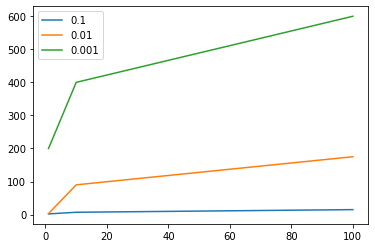

,0.100,0.010,0.001
1,2,3,279
10,5,87,747
100,8,85,1000


<Figure size 432x288 with 0 Axes>

<AxesSubplot:>

<Figure size 432x288 with 0 Axes>

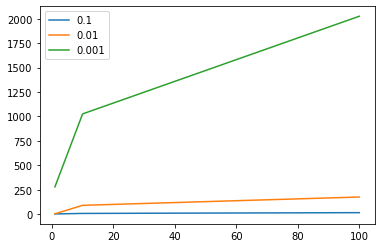

,0.100,0.010,0.001
1,2,3,279
10,5,87,747
100,8,85,1101


<Figure size 432x288 with 0 Axes>

<AxesSubplot:>

<Figure size 432x288 with 0 Axes>

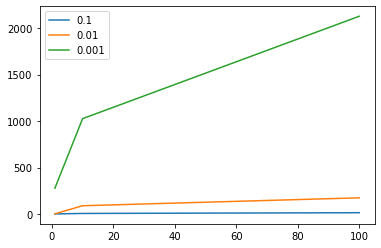

In [33]:
X = np.absolute(np.random.rand(500,1000))
l = 0.5
ks = [1,10,100]
epsValues = [0.1,0.01,0.001]
plt.figure()
for maxIters in [200,1000,10000]:
    iters = []
    for k in ks:
        row = []
        for epsilon in epsValues:
            W,C, n_iter = RegNMF(X,k,l,epsilon)
            row.append(n_iter)
        iters.append(row)
    df = pd.DataFrame(iters, index=ks, columns=epsValues)
    df
    df = df.cumsum()
    df.plot()
    plt.show()

Τα παραπάνω διαγράμματα αποτελούν οπτικοποιήσεις των πινάκων, όπου στον οριζόντιο άξονα
βρίσκεται η τιμή του k, στον κάθετο άξονα ο αριθμός των επαναλήψεων ενώ κάθε γραμμή
δείχνει την τιμή του ζητούμενου σφάλματος. Από τα διαγράμματα παρατηρούμε: <br>

1. Αναλογία μεταξύ των τιμών k, tol. Όσο αυξάνεται η ακρίβεια του σφάλματος και του αριθμού των συνιστωσών
τόσο περισσότερες επαναλήψεις απαιτεί ο αλγόριθμος. <br>
2. Για σταθερό k παρατηρούμε πως υπάρχει σχεδόν αναλογική αυξηση των επαναλήψεων μεταξύ των διαφορετικών
σφαλμάτων. <br>
3. Ομοίως απο τα διαγράμματα προκύπτει πως με σταθερό σφάλμα η αύξηση των συνιστωσών απαιτεί αύξηση των
επαναλήψεων για να επιτευχθεί σύγκλιση.
